# Simulation for Uniform Convergence of Lipschitz Functions with Dependent Gaussian Samples

## License
This project is released under the **GNU General Public License v3 (GPLv3)**.  
You are free to use, modify, and distribute this code under the terms of the GPLv3 license.  
For more details, see: [GNU GPL v3](https://www.gnu.org/licenses/gpl-3.0.en.html).

## Authors
- **Mina Sadat Mahmoudi**  
- **Saeed Foroutan**  
- **Seyed Abolfazl Motahari**  
- **Babak Khalaj**  
- Department of Electrical Engineering & Computer Engineering, Sharif University of Technology, Iran

## Conference & Publication
This work has been **accepted** for presentation at the **IEEE International Conference on Acoustics, Speech, and Signal Processing (ICASSP) 2025**.

---

## Overview

This Jupyter notebook contains simulations related to the paper:

**"Uniform Convergence of Lipschitz Functions with Dependent Gaussian Samples"**  
It will present at **ICASSP 2025** by researchers from **Sharif University of Technology**.

### Purpose

In this notebook, we present numerical experiments and real-world applications to validate the theoretical results of the paper. The focus is on:

- Studying uniform convergence properties of Lipschitz functions under dependent Gaussian data.
- Empirical error decay in different dependency scenarios.
- Real-world applications, including time series forecasting and financial modeling.

### Methodology

The simulations primarily utilize:
- **Auto-regressive models** to generate dependent Gaussian samples.
- **Neural networks and regression models** for function approximation.
- **Mean Absolute Error (MAE)** as the primary evaluation metric.

The theoretical results demonstrated in this work provide insights into learning under dependent data settings, particularly relevant to fields such as time series forecasting and neural network training.

---



## Importing Required Libraries

This notebook utilizes several key libraries for data processing, machine learning, and visualization:

- **pandas**: For handling structured data and dataframes.
- **numpy**: For numerical operations and matrix manipulations.
- **torch (PyTorch)**: For deep learning and neural network modeling.
- **torch.nn**: For defining and training neural networks.
- **torch.optim**: For optimization algorithms like SGD and Adam.
- **matplotlib.pyplot**: For creating plots and visualizations.
- **datetime**: For handling date and time operations.
- **seaborn**: For advanced statistical visualizations.



In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns

## Defining Experiment Parameters

- **`samples`**: A list of different training sample sizes `[5, 10, 15, 20, 50]` used in the simulations.
- **`N_iter`**: The number of iterations set to `1000` for repeated experiments.
- **`N_train`**: The number of training samples per iteration, set to `100`.


In [ ]:
from typing_extensions import NamedTuple
samples = [5,10,15,20,50]
N_iter = 1000
N_train = 100

## Generating Dependent Gaussian Samples

### `generate_x(gamma, n)`

This function generates a sequence of **dependent Gaussian samples** using an **autoregressive (AR) model**:

- **`gamma`**: The dependency factor (`0 ≤ gamma ≤ 1`), controlling the correlation between consecutive samples.
- **`n`**: The number of samples to generate.

### Method:
- Initializes `x[0]` from a standard normal distribution (`N(0,1)`).
- Iteratively generates `x[t]` based on:
$
  x_t = \gamma x_{t-1} + \sqrt{1 - \gamma^2} G
$
  where `G ~ N(0,1)` is a new independent Gaussian noise term.

This function simulates **Gaussian data with controlled dependence**.

In [ ]:
def generate_x(gamma, n):
  x = np.zeros(n)  # Initialize the sequence array

  # Initialize x0 from N(0, 1)
  x[0] = np.random.normal(0, 1)

  # Generate the sequence
  for t in range(1, n):
      G = np.random.normal(0, 1)
      x[t] = gamma * x[t - 1] + np.sqrt(1 - gamma**2) * G
  return x



## Generating i.i.d. Gaussian Test Samples

### `generate_x_test(length)`

This function generates a sequence of **independent and identically distributed (i.i.d.) Gaussian samples**:

- **`length`**: The number of test samples to generate.

### Method:
- Draws `length` samples from a standard normal distribution:
$x \sim \mathcal{N}(0,1)$

This function is primarily used for **testing purposes**, where data points are assumed to be **independent (i.i.d.)** rather than dependent.


In [ ]:

#This is for Test set creating.
def generate_x_test(length):
    return np.random.normal(loc=0.0, scale=1.0, size=length)

## Labeling Function: `Labling_Function(xtz, add_noise=True)`

This function defines a **piecewise function** used for generating labeled data based on input values. It applies different mathematical transformations to the input `xtz` after scaling it by a factor of `5`.

### Parameters:
- **`xtz`**: The input sample (scalar), which is transformed before applying piecewise conditions.
- **`add_noise`** (`bool`, default=`True`): If `True`, adds **Gaussian noise** (`N(0, 0.05)`) to the output.

### Function Behavior:
- Scales `xtz` by **5** (`xt = xtz * 5`).
- Applies different **piecewise transformations** based on `xt`:
  - **Cosine transformation** for small values.
  - **Square root function** for moderate values.
  - **Quadratic function** for mid-range values.
  - **Linear transformation** for large values.

### Output:
- Returns the computed function value, optionally **with added Gaussian noise**.



In [ ]:
def Labling_Function(xtz, add_noise=True):
    xt = xtz * 5
    # Evaluate the piecewise conditions
    if abs(xt) <= 1:
        result = 2 + np.cos(np.pi * xt)
    elif 1 < abs(xt) <= 4:
        result = np.sqrt(abs(xt))
    elif 4 < abs(xt) <= 5:
        result = -(abs(xt) - 3)**2 + 3
    elif 5 < abs(xt) <= 6:
        result = 2 * abs(xt) - 11
    elif 6 < abs(xt) <= 7:
        result = 2 + np.cos(np.pi * (2* abs(xt) - 13))
    elif 7 < abs(xt) <= 10:
        result = np.sqrt(abs(xt) - 6)
    elif 10 < abs(xt) <= 11:
        result = -(abs(xt) - 9)**2 + 3
    elif 11 < abs(xt):
        result = 2 * abs(xt) - 23

    # Add noise if requested
    if add_noise:
        result += np.random.normal(0, 0.05)

    return result

## Checking the Continuity of the Labeling Function

This section visualizes the **Labeling Function** to inspect its **continuity properties**.

### Methodology:
- Generates **400 evenly spaced** values of `x` in the range **[-4, 4]**.
- Evaluates the **Labeling Function** at each `x` without adding noise.
- Plots the function using **Matplotlib** to examine its behavior.

### Expected Observations:
- A continuous function should have a **smooth curve** without abrupt jumps.
- If discontinuities exist, we expect to see **sharp breaks or gaps** in the plot.

The visualization helps determine if the function exhibits **uniform continuity** or if there are points where the function is **not well-defined**.


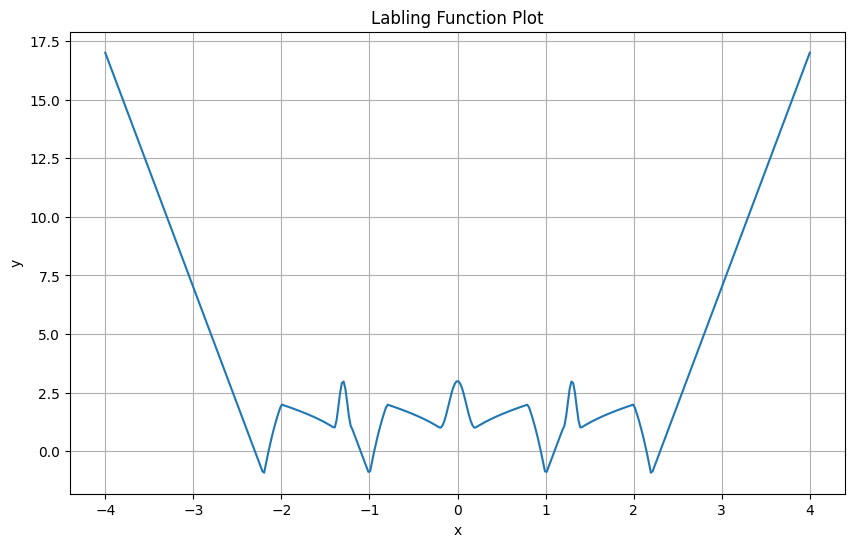

In [ ]:


x_values = np.linspace(-4, 4, 400)  # Generate a range of x values
y_values = [Labling_Function(x, False) for x in x_values]

plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Labling Function Plot")
plt.grid(True)
plt.show()

## Tensor Conversion Function

Converts input `x` into a **PyTorch tensor** with `float32` dtype and adds an extra dimension for batch processing.


In [ ]:
def tensorize(x):
  return torch.tensor(x, dtype=torch.float32).unsqueeze(1)


## Three-Layer Neural Network for Function Approximation

This section defines and trains a **three-layer neural network (NN)** to approximate the **Labeling Function**.

### Components:
- **`ThreeLayerNN`**: A feedforward NN with **two hidden layers (10 neurons each)** and **ReLU activations**.
- **`custom_loss`**: Mean Absolute Error (MAE) is used as the loss function.
- **`train_model(x, y)`**: Trains the NN using **Adam optimizer** for `1000` epochs.
- **`predict(model, input)`**: Uses the trained model to make predictions.

The model learns to approximate the function by minimizing the MAE over the given training samples.


In [ ]:


# Define a 3-layer neural network
class ThreeLayerNN(nn.Module):
    def __init__(self):
        super(ThreeLayerNN, self).__init__()
        self.fc1 = nn.Linear(1, 10)  # Input layer to hidden layer (10 neurons)
        self.fc2 = nn.Linear(10, 10)  # Hidden layer to another hidden layer
        self.fc3 = nn.Linear(10, 1)   # Hidden layer to output layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x





In [ ]:

# Define the loss function (Mean absolute error as shown in the equation)
def custom_loss(output, target):
    return torch.mean(torch.abs(output - target))



In [ ]:
def train_model(x,y):
  x_tensor, y_tensor = tensorize(x), tensorize(y)

  # Reinitialize the model for every training
  model = ThreeLayerNN()

  # Define optimizer
  optimizer = optim.Adam(model.parameters(), lr=0.01)

  # Train the model
  num_epochs = 1000
  for epoch in range(num_epochs):
      model.train()

      # Forward pass
      outputs = model(x_tensor)
      loss = custom_loss(outputs, y_tensor)

      # Backward pass and optimization
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Print loss every 100 epochs
      if (epoch+1) % 100 == 0:
          print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
  return model


In [ ]:
def predict(model, input):
  return model(input).detach().numpy()

## Expected Error Calculation for Dependent and Independent Samples

This section evaluates the **expected error** of the trained model under **dependent and independent** data conditions.

### 1️⃣ `process_for_expected_error(gamma, samples, label_function, iterations)`
- Used for **dependent Gaussian samples**, corresponding to `γ = 0.1` and `γ = 0.9` in the paper.
- **Steps:**
  - Generates a sequence `x` using **`generate_x(gamma, samples)`**.
  - Computes labels `y` using the `label_function`.
  - Trains a neural network using `(x, y)`.
  - Estimates the **expected absolute error** over multiple test iterations.

### 2️⃣ `process_for_expected_error_iid(samples, label_function, iterations)`
- Used for **i.i.d. Gaussian samples**, corresponding to `γ = 0` in the paper.
- **Steps:**
  - Generates `x` using **`generate_x_test(samples)`** (independent samples).
  - Computes labels `y` using the `label_function`.
  - Trains the model and evaluates expected error using new **i.i.d. test samples**.

### Purpose:
- Compares the model’s **expected error decay** for different **dependency structures**.
- Helps validate the **theoretical uniform convergence results** under both **dependent and independent** settings.


In [ ]:
def process_for_expected_error(gamma, samples, label_function, iterations):
  # First, we generate x.
  x = generate_x(gamma, samples)

  # Generate the y sequence based on the previously generated x sequence
  y = np.array([label_function(xi) for xi in x])

  # Train the model
  trained_model = train_model(x,y)

  # initialize the sum_error
  sum_error = []
  # We want to calculate the expected value (omid riazi) of error for number of iterations
  for i in range(iterations):
    x1 = generate_x_test(1)
    y1 = np.array([label_function(xi) for xi in x1])
    y_pred1 = predict(trained_model,tensorize(x1))
    #print(f"y_pred: {y_pred1[0][0]}")
    #print(f"y: {y1[0]}")
    #print(f"error: {abs(y1[0]-y_pred1[0][0])}")
    sum_error.append(abs(y1[0]-y_pred1[0][0]))

  return sum_error


In [ ]:
def process_for_expected_error_iid(samples, label_function, iterations):
  # First, we generate x.
  x = generate_x_test(samples)

  # Generate the y sequence based on the previously generated x sequence
  y = np.array([label_function(xi) for xi in x])

  # Train the model
  trained_model = train_model(x,y)

  # initialize the sum_error
  sum_error = []
  # We want to calculate the expected value (omid riazi) of error for number of iterations
  for i in range(iterations):
    x1 = generate_x_test(1)
    y1 = np.array([label_function(xi) for xi in x1])
    y_pred1 = predict(trained_model,tensorize(x1))
    #print(f"y_pred: {y_pred1[0][0]}")
    #print(f"y: {y1[0]}")
    #print(f"error: {abs(y1[0]-y_pred1[0][0])}")
    sum_error.append(abs(y1[0]-y_pred1[0][0]))

  return sum_error


## Boxplot of Prediction Errors Across Dependency Levels  

This function visualizes the **prediction error distribution** for **highly dependent (γ = 0.9)**, **low dependency (γ = 0.1)**, and **independent (γ = 0)** samples across different training sizes using a **box plot**.


In [ ]:
def plot_boxplot(data_highly_temporal, data_low_temporal, data_independent):
    """
    This function takes in three datasets (each containing 5 lists of numbers) and plots a boxplot
    with three categories: highly temporally dependent, low temporally dependent, and independent.

    Parameters:
    data_highly_temporal (list of lists): Data for the "highly temporally dependent" category.
    data_low_temporal (list of lists): Data for the "low temporally dependent" category.
    data_independent (list of lists): Data for the "independent" category.
    """


    # Labels for the sample sizes (repeated across all three categories)
    labels = ['5', '10', '15', '20', '50'] * 3  # Sample sizes repeated for all three categories

    # Flatten the data, labels, and groupings
    flattened_data = []
    flattened_labels = []
    flattened_groupings = []

    for i, dataset in enumerate([data_highly_temporal, data_low_temporal, data_independent]):
        if i == 0:
            group = 'Highly Temporally Dependent'
        elif i == 1:
            group = 'Slightly Temporally Dependent'
        else:
            group = 'Independent'

        for j, sample_data in enumerate(dataset):
            flattened_data.extend(sample_data)
            flattened_labels.extend([labels[j]] * len(sample_data))
            flattened_groupings.extend([group] * len(sample_data))

    # Create box plot with appropriate styling
    plt.figure(figsize=(10, 6))  # Set the figure size
    sns.set(style="whitegrid")

    # Define a palette for the three categories
    palette = {
        'Highly Temporally Dependent': 'orange',
        'Slightly Temporally Dependent': 'yellow',
        'Independent': 'green'
    }

    # Create the box plot
    box = sns.boxplot(
        x=flattened_labels,
        y=flattened_data,
        hue=flattened_groupings,
        palette=palette,
        linewidth=3,
        width=0.8,  # Increase the width of the boxes
        dodge=True,  # Add more space between the categories
        showfliers=False
    )

    # Increase font size for axis labels
    box.set_xlabel('Sample Size', fontsize=16)
    box.set_ylabel('Average Prediction Error', fontsize=16)

    # Increase tick label font size
    box.tick_params(axis='x', labelsize=14)
    box.tick_params(axis='y', labelsize=14)

    # Manually adjust legend with formatted labels
    handles, _ = box.get_legend_handles_labels()
    plt.legend(
        handles,
        [
            r'Highly Temporally Dependent ($\gamma = 0.9$)',
            r'Slightly Temporally Dependent ($\gamma = 0.1$)',
            r'Independent ($\gamma = 0$)'
        ],
        title='',
        fontsize=16
    )

    # Show gridlines
    plt.grid(True, linestyle='--', alpha=0.7)

    # Display the plot
    plt.show()


## Computing Expected Errors Across Dependency Levels

This section computes the **expected prediction error** for different dependency levels:

- **`list_of_expected_errors_one_noise`**: Errors for **low dependency** (`γ = 0.1`).
- **`list_of_expected_errors_nine_noise`**: Errors for **high dependency** (`γ = 0.9`).
- **`list_of_expected_errors_iid_noise`**: Errors for **i.i.d. data** (`γ = 0`).

For each **sample size**, the model is trained **100 times (`N_train`)**, and the mean absolute error is averaged over **`N_iter` iterations** to estimate the expected error.


In [ ]:
list_of_expected_errors_one_noise = []
number_of_iters = N_iter
for sample in samples:
  list_of_ex_error = []
  for i in range(N_train):
    ex_error = process_for_expected_error(gamma = 0.1, samples=sample, label_function=Labling_Function, iterations = number_of_iters )
    list_of_ex_error.append(sum(ex_error)/number_of_iters)
  list_of_expected_errors_one_noise.append(list_of_ex_error)

Epoch [100/1000], Loss: 0.4387
Epoch [200/1000], Loss: 0.3351
Epoch [300/1000], Loss: 0.2866
Epoch [400/1000], Loss: 0.2257
Epoch [500/1000], Loss: 0.2015
Epoch [600/1000], Loss: 0.1723
Epoch [700/1000], Loss: 0.1806
Epoch [800/1000], Loss: 0.1737
Epoch [900/1000], Loss: 0.1763
Epoch [1000/1000], Loss: 0.1849
Epoch [100/1000], Loss: 0.2893
Epoch [200/1000], Loss: 0.2832
Epoch [300/1000], Loss: 0.2758
Epoch [400/1000], Loss: 0.2691
Epoch [500/1000], Loss: 0.2590
Epoch [600/1000], Loss: 0.2418
Epoch [700/1000], Loss: 0.2207
Epoch [800/1000], Loss: 0.1859
Epoch [900/1000], Loss: 0.1789
Epoch [1000/1000], Loss: 0.1464
Epoch [100/1000], Loss: 0.4696
Epoch [200/1000], Loss: 0.4673
Epoch [300/1000], Loss: 0.4495
Epoch [400/1000], Loss: 0.3744
Epoch [500/1000], Loss: 0.3879
Epoch [600/1000], Loss: 0.3580
Epoch [700/1000], Loss: 0.3534
Epoch [800/1000], Loss: 0.3490
Epoch [900/1000], Loss: 0.3433
Epoch [1000/1000], Loss: 0.3544
Epoch [100/1000], Loss: 0.1340
Epoch [200/1000], Loss: 0.1337
Epoch

In [ ]:
list_of_expected_errors_nine_noise = []
number_of_iters = N_iter
for sample in samples:
  list_of_ex_error = []
  for i in range(N_train):
    ex_error = process_for_expected_error(gamma = 0.9, samples=sample, label_function=Labling_Function, iterations = number_of_iters )
    list_of_ex_error.append(sum(ex_error)/number_of_iters)
  list_of_expected_errors_nine_noise.append(list_of_ex_error)

Epoch [100/1000], Loss: 0.3449
Epoch [200/1000], Loss: 0.0517
Epoch [300/1000], Loss: 0.0520
Epoch [400/1000], Loss: 0.0194
Epoch [500/1000], Loss: 0.0168
Epoch [600/1000], Loss: 0.0215
Epoch [700/1000], Loss: 0.0129
Epoch [800/1000], Loss: 0.0096
Epoch [900/1000], Loss: 0.0177
Epoch [1000/1000], Loss: 0.0198
Epoch [100/1000], Loss: 0.0299
Epoch [200/1000], Loss: 0.0280
Epoch [300/1000], Loss: 0.0263
Epoch [400/1000], Loss: 0.0271
Epoch [500/1000], Loss: 0.0265
Epoch [600/1000], Loss: 0.0275
Epoch [700/1000], Loss: 0.0289
Epoch [800/1000], Loss: 0.0293
Epoch [900/1000], Loss: 0.0293
Epoch [1000/1000], Loss: 0.0277
Epoch [100/1000], Loss: 0.7004
Epoch [200/1000], Loss: 0.6646
Epoch [300/1000], Loss: 0.5839
Epoch [400/1000], Loss: 0.5158
Epoch [500/1000], Loss: 0.4253
Epoch [600/1000], Loss: 0.4042
Epoch [700/1000], Loss: 0.4124
Epoch [800/1000], Loss: 0.3579
Epoch [900/1000], Loss: 0.3417
Epoch [1000/1000], Loss: 0.3480
Epoch [100/1000], Loss: 0.2020
Epoch [200/1000], Loss: 0.0757
Epoch

In [ ]:
list_of_expected_errors_iid_noise = []
number_of_iters = N_iter
for sample in samples:
  list_of_ex_error = []
  for i in range(N_train):
    ex_error = process_for_expected_error_iid(samples=sample, label_function=Labling_Function, iterations = number_of_iters )
    list_of_ex_error.append(sum(ex_error)/number_of_iters)
  list_of_expected_errors_iid_noise.append(list_of_ex_error)

Epoch [100/1000], Loss: 0.2358
Epoch [200/1000], Loss: 0.1316
Epoch [300/1000], Loss: 0.1316
Epoch [400/1000], Loss: 0.1339
Epoch [500/1000], Loss: 0.1317
Epoch [600/1000], Loss: 0.1284
Epoch [700/1000], Loss: 0.1347
Epoch [800/1000], Loss: 0.1279
Epoch [900/1000], Loss: 0.1296
Epoch [1000/1000], Loss: 0.1391
Epoch [100/1000], Loss: 0.1787
Epoch [200/1000], Loss: 0.1022
Epoch [300/1000], Loss: 0.0549
Epoch [400/1000], Loss: 0.0268
Epoch [500/1000], Loss: 0.0357
Epoch [600/1000], Loss: 0.0135
Epoch [700/1000], Loss: 0.0110
Epoch [800/1000], Loss: 0.0094
Epoch [900/1000], Loss: 0.0068
Epoch [1000/1000], Loss: 0.0100
Epoch [100/1000], Loss: 0.2222
Epoch [200/1000], Loss: 0.1740
Epoch [300/1000], Loss: 0.1448
Epoch [400/1000], Loss: 0.1182
Epoch [500/1000], Loss: 0.0887
Epoch [600/1000], Loss: 0.0276
Epoch [700/1000], Loss: 0.0307
Epoch [800/1000], Loss: 0.0242
Epoch [900/1000], Loss: 0.0206
Epoch [1000/1000], Loss: 0.0127
Epoch [100/1000], Loss: 0.2848
Epoch [200/1000], Loss: 0.2870
Epoch

## Visualizing Expected Prediction Errors

This section assigns the computed expected errors to variables:

- **`data_one_noise`** → Low dependency (`γ = 0.1`)
- **`data_nine_noise`** → High dependency (`γ = 0.9`)
- **`data_iid_noise`** → Independent data (`γ = 0`)

The function **`plot_boxplot()`** is then used to visualize the distribution of errors across different **sample sizes** and **dependency levels** using a boxplot.


In [ ]:

data_one_noise = list_of_expected_errors_one_noise
data_nine_noise = list_of_expected_errors_nine_noise
data_iid_noise = list_of_expected_errors_iid_noise


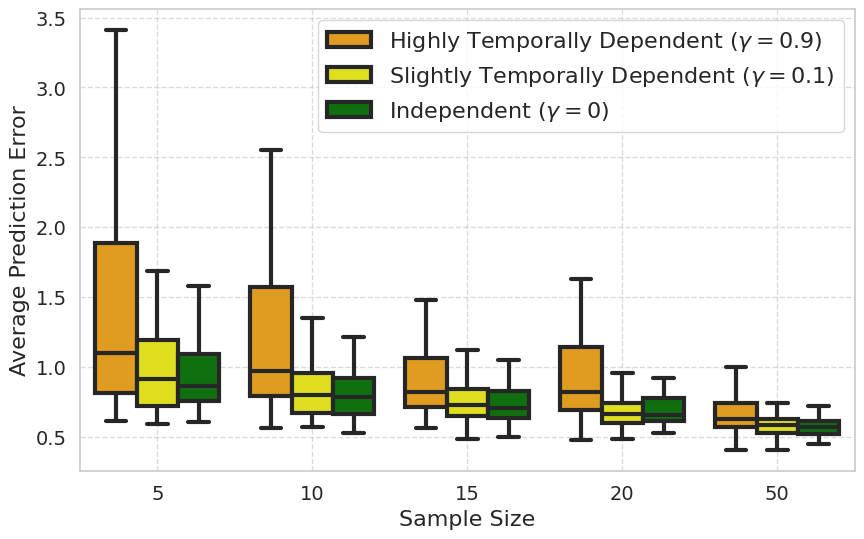

In [ ]:
plot_boxplot(data_nine_noise, data_one_noise, data_iid_noise)